# Session 1.2.  Positions, Distances and Trajectories 


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

Authors: 

- Dr Micaela Matta - micaela.matta@kcl.ac.uk 
- Dr Richard Gowers - richardjgowers@gmail.com
- Dr Irfan Alibay - ialibay@gmail.com

This notebook is adapted from materials developed for the [2021 PRACE Workshop](https://github.com/MDAnalysis/WorkshopPrace2021) and the [2018 Workshop/Hackathon](https://github.com/MDAnalysis/WorkshopHackathon2018)

## Google Colab package installs

This installs the necessary packages for Google Colab. Please only run these if you are using Colab.

In [2]:
# NBVAL_SKIP
!if [ -n "$COLAB_GPU" ]; then pip install condacolab; fi
import condacolab
condacolab.install()

ModuleNotFoundError: No module named 'condacolab'

In [ ]:
# NBVAL_SKIP
import condacolab
condacolab.check()
!mamba install -c conda-forge mdanalysis mdanalysistests mdanalysisdata nglview

In [3]:
# NBVAL_SKIP
# enable third party jupyter widgets
from google.colab import output
output.enable_custom_widget_manager()

ModuleNotFoundError: No module named 'google'

## **Jupyter cheat sheet**:
- to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;

<div class="alert alert-warning"><b> REMEMBER: variables persist between cells</b> 
    
Be aware that it is the order of execution of cells that is important in a Jupyter notebook, not the <em>order</em> in which they appear. Python will remember <em>all</em> the code that was run previously, including any variables you have defined, irrespective of the order in the notebook. Therefore if you define variables lower down the notebook and then (re)run cells further up, those defined further down will still be present. </div> 


## Learning outcomes:


* How to access atom positions

* Calculating bonds and distances  

* Calculating angles

* How box information is stored and how this relates to periodic boundaries, wrapping/unwrapping 

* Efficient distance calculations and sparse arrays

* Loading trajectories, iterating over frames and selecting frames

## Additional resources
 - During the workshop, feel free to ask questions at any time
 - For more on how to use MDAnalysis, see the [User Guide](https://userguide.mdanalysis.org/2.0.0-dev0/) and [documentation](https://docs.mdanalysis.org/2.0.0-dev0/)
 - Ask questions on the [user mailing list](https://groups.google.com/group/mdnalysis-discussion) or on [Discord](https://discord.gg/fXTSfDJyxE)
 - Report bugs on [GitHub](https://github.com/MDAnalysis/mdanalysis/issues?)


## Table of Contents

1. [Atom positions](#positions)  
2. [Bonds and Distances: end-to-end distance](#bonds)    
3. [Calculating Angles: AdK opening](#angles)     
4. [More distances and angles: hydrogen bonds of PEG in water](#distarrays)
5. [Trajectories and Frames](#trajectory)
6. [Analysing trajectories](#trajanalysis)

### Imports

We start with the usual imports:

In [25]:
import MDAnalysis as mda
import MDAnalysisData as data
import nglview
import numpy as np
import matplotlib.pyplot as plt

### Example: a PEG chain in water

Load a dataset from `MDAnalysisData`: a PEG - poly(ethyleneglycol) chain $HO(CH2CH2)_{20}OH$ in water

In [10]:
PEG_example = data.datasets.fetch_PEG_1chain()

Create a Universe by loading the topology and coordinates:

In [11]:
peg_u = mda.Universe(PEG_example['topology'], PEG_example['trajectory'])

We loaded a trajectory with 50 frames, but for the first part of this tutorial we'll limit ourselves to look at one frame.

The polymer is the first residue:

In [ ]:
peg = peg_u.atoms.residues[0]

### Visualize the system with `nglview`

`nglview` takes either a `Universe` or an `AtomGroup` as input:

In [ ]:
poly = nglview.show_mdanalysis(peg)
poly

## Atom positions
<a id='positions'></a>

The most important attribute of your atoms is undoubtedly their positions! The position information is made available via an `AtomGroup` in the `positions` attribute:

In [ ]:
Os = peg_u.select_atoms('type os')

Os.positions

this returns a numpy array with x, y and z coordinates.

### Center of geometry

We can use `numpy` functions to manipulate coordinates. For instance, we can calculate the center of geometry:

In [ ]:
cog = np.mean(Os.positions, axis=0)
print(cog)

<div class="alert alert-info"> 
    
`AtomGroups` **and built-in functions** 

MDAnalysis `AtomGroups` have a convenient `center_of_mass()` method to get their center of mass at the current frame. 
Other  methods for common calculations based on positions include `center_of_geometry()`, `radius_of_gyration()` and `principal_axes()`. </div> 

In [ ]:
Os.center_of_geometry()

### Exercise: calculate radius of gyration of PEG

Using the `radius_of_gyration()` function, calculate the radius of gyration of PEG:

In [ ]:
#select polymer as the first residue:
peg_chain = peg_u.residues[0]

rog = peg_chain.atoms.radius_of_gyration()


print(rog)

##  Bonds and Distances
<a id='bonds'></a>

### End-to-end distance of a PEG chain 

We can use the hydrogens in the capping -OH groups (`type ho`) as reference points. First, select the two hydrogen atoms:

In [ ]:
Hb, He = peg_u.atoms.select_atoms("type ho")

In [ ]:
np.linalg.norm(Hb.position - He.position)

<div class="alert alert-info"><b> Built-in functions 2: bonds</b>
    
`MDAnalysis.lib.distances` has a `calc_bonds` method which allows users to calculate periodic aware distances between two sets of positions. </div> 

Then, calculate the distance between their coordinates:

In [ ]:
mda.lib.distances.calc_bonds(Hb.position, He.position, box=peg_u.dimensions)

## Calculating Angles
<a id='angles'></a>

In [77]:
from MDAnalysisData.datasets import fetch_adk_transitions_DIMS
adk = fetch_adk_transitions_DIMS()
adk_u = mda.Universe(adk.topology, adk.trajectories[:1])

### AdK angles

The enzyme *adenylate kinase* catalyzes the reaction ATP + AMP <-> 2 ADP. 

It undergoes a *conformational transition* beteween a closed ([1AKE](https://www.rcsb.org/structure/1AKE)) and open ([4AKE](https://www.rcsb.org/structure/4AKE)) conformational state [1], even in the absence of substrates.

<center><img src="imgs/adk.png" alt="mda" style="width: 300px;"/></center>
1. S. L. Seyler and O. Beckstein. Sampling of large conformational transitions: Adenylate kinase as a testing ground. Molec. Simul., 40(10–11):855–877, 2014. doi: 10.1080/08927022.2014.919497

Let's look in more detail at the AdK protein. AdK has three domains:

 - CORE (residues 1-29, 60-121, 160-214)
 - NMP (residues 30-59)
 - LID (residues 122-159)

Angles between these domains can be used to distinguish open and closed states of the AdK protein. These angles are defined between the center of geometry of the backbone and C$_\beta$ atoms of the following groups of atoms:

 - $\theta_{NMP}$ is defined between residues:
   - A: 115-125 
   - B: 90-100
   - C: 35-55
 - $\theta_{LIC}$ is defined between residues:
   - A: 179-185
   - B: 112-125
   - C: 125-153 



The angle between two vectors is given by:

$$\theta = arccos\left( \frac{\vec{BA}\cdot\vec{BC}}{|\vec{BA}||\vec{BC}|} \right)$$

We first define the coordinate centers for each residue by using `center_of_geometry`:

In [ ]:
A_NMP = adk_u.select_atoms('resid 115-125 and (backbone or name CB)').center_of_geometry()
B_NMP = adk_u.select_atoms('resid 90-100 and (backbone or name CB)').center_of_geometry()
C_NMP = adk_u.select_atoms('resid 35-55 and (backbone or name CB)').center_of_geometry()

A_LID = adk_u.select_atoms('resid 179-185 and (backbone or name CB)').center_of_geometry()
B_LID = adk_u.select_atoms('resid 112-125 and (backbone or name CB)').center_of_geometry()
C_LID = adk_u.select_atoms('resid 125-153 and (backbone or name CB)').center_of_geometry()

### the `numpy` way 


You can use `numpy.linalg.norm()` to calculate the norm of a vector. Numpy also has functions `numpy.arccos()` and `numpy.dot()`:

In [ ]:
import numpy as np
from numpy.linalg import norm

# define vectors BA and BC
BA_NMP = A_NMP - B_NMP
BC_NMP = C_NMP - B_NMP

# calculate theta_NMP
theta_NMP = np.arccos(np.dot(BA_NMP, BC_NMP)/(norm(BA_NMP)*norm(BC_NMP)))

print('theta_NMP: ', np.rad2deg(theta_NMP))

# define vectors BA and BC
BA_LID = A_LID - B_LID
BC_LID = C_LID - B_LID

# calculate theta_LID
theta_LID = np.arccos(np.dot(BA_LID, BC_LID)/(norm(BA_LID)*norm(BC_LID)))

print('theta_LID: ', np.rad2deg(theta_LID))

<div class="alert alert-info"><b> Built-in functions 3: angles and dihedrals</b> 
    
`MDAnalysis.lib.distances` has a `calc_angles` method which allows users to calculate periodic aware angles between 3 array-like sets of positions. 
    
In the same way, it is possible to calculate dihedrals with `calc_dihedrals`. </div> 

### the  `MDAnalysis` way

There's an alternative, much faster way! 
Let's use `calc_angles` to get the angles $\theta_{NMP}$ and $\theta_{LID}$:

In [ ]:
theta_NMP = mda.lib.distances.calc_angles(A_NMP, B_NMP, C_NMP)
theta_LID = mda.lib.distances.calc_angles(A_LID, B_LID, C_LID)

print('theta_NMP: ', np.rad2deg(theta_NMP))
print('theta_LID: ', np.rad2deg(theta_LID))

`calc_angles`, like all `MDAnalysis.lib.distances` functions, has an optional argument to specify periodic boundary conditions:

```
 mda.lib.distances.calc_angles(
    coords1,
    coords2,
    coords3,
    box=None,
    result=None,
    backend='serial')
   ``` 
    

## More distances and angles: hydrogen bonds in PEG
<a id='distarrays'></a>

This example will show you how to use various functions in `MDAnalysis.lib.distances` to identify hydrogen bonding between certain residues and the water solvent.

A hydrogen bond (in the context of this analysis) will be defined as an interaction between three atoms:
- An acceptor, which is attracting the hydrogen
- A hydrogen, which is being pulled into the acceptor
- A donor, which is bonded to the hydrogen and being dragged along for the ride.

We will use the following geometric criteria:
- a hydrogen-acceptor distance of 3.0A 
- an acceptor-hydrogen-donor angle of greater than 120 degrees.

We can go back to our PEG chain in water. Oxygen atoms in PEG can accept hydrogen bonds from water:

In [12]:
# select oxygen atoms - types os and oh
acceptors = peg_u.atoms.select_atoms("type os oh")

Select hydrogens (from water):

In [13]:
hydrogens = peg_u.atoms.select_atoms("type HW")

### Distance criteria

We first want to identify hydrogens and acceptors that are within our distance criteria of 3.0 angstrom.
A naive approach is to calculate a `distance_array` between all acceptors and all hydrogens.:

In [ ]:
%%time

da = mda.lib.distances.distance_array(acceptors.positions, hydrogens.positions, box=peg_u.dimensions)

<div class="alert alert-info"><b>HINT</b>

`np.where` is a handy function for returning the *indices* of where a condition is True.  Here we use it to extract the row and column numbers of where an entry in a distance matrix is less than 3.0.</div>
     

In [ ]:
acc_idx, hyd_idx = np.where(da < 3.0)

### Using `capped_distance`

This is a great example of where we're not interested in all distances, but instead only those up to a given cutoff - Using `capped_distance` is much quicker here!

<div class="alert alert-info"><b>Reminder</b> 

The output of `capped_distance` is no longer a matrix, but an array of indices and the distance values at those indices.  This can be thought of as a sparse matrix.
 </div>

Try experimenting with the cutoff distance to see how the time required varies.

In [19]:
%%time 

idx, dists = mda.lib.distances.capped_distance(acceptors.positions, hydrogens.positions, max_cutoff=3.0,
                                            box=peg_u.dimensions)

CPU times: user 1.26 ms, sys: 775 µs, total: 2.03 ms
Wall time: 1.06 ms


**TIP:** by adding the argument `return_distances=False` to `capped_distance`, we can avoid returning distances and keep just the *indices*.



The `idx` array is a `(n, 2)` array of indices; to grab the first and second column, we can transpose the array (`.T`) and assign each row to a variable, `acc_idx` for the *indices* of the acceptors and `hyd_idx` for the *indices* of the hydrogen atoms.

In [20]:
acc_idx, hyd_idx = idx.T

Remembering that we can slice `AtomGroup`s with numpy arrays, we can use these indices arrays to slice our original `AtomGroup`s to filter them down and make them smaller.

In [21]:
# select potential hydrogen bonds to check angles
potential_hbond_acceptors = acceptors[acc_idx]
potential_hbond_hydrogens = hydrogens[hyd_idx]

To get the **donors** for each hydrogen bond is slightly trickier.
We can use the fact that hydrogens will only have one covalent bond, and simply loop over the hydrogen atoms, grabbing the first (and only) bonded atom of each. 

In [23]:
potential_hbond_donors = sum(h.bonded_atoms[0] for h in potential_hbond_hydrogens)

<div class="alert alert-info"><b>Reminder</b>  

A `sum()` over `MDAnalysis.Atom` objects will produce an `AtomGroup`!

</div>

### Checking the angle criteria

Now that we've identified hydrogens and acceptors which are close enough for a hydrogen bond, we can now check our angular criteria.
The angle formed by the acceptor-hydrogen-donor must be greater than 120 degrees!


<div class="alert alert-info"><b>Reminder</b>  
    
The input to `calc_angles` must be in the correct order, with the second array of positions being the vertex of the angle.  Results are returned in radians!
 </div>

By first checking the distance criteria and filtering down our input, we greatly reduce the number of angles we must calculate.
This is important as angles calculations are computationally more expensive than distance calculations.

In [27]:
angles = np.rad2deg(
    mda.lib.distances.calc_angles(potential_hbond_acceptors.positions,
                                  potential_hbond_hydrogens.positions,
                                  potential_hbond_donors.positions, box=peg_u.dimensions)
)

Again we can use `np.where` to get the *indices* of where a condition is True, here if a value is above 120.

In [28]:
angle_idx = np.where(angles >= 120.0)

Finally, we can slice our list of candidate atoms with `angle_idx` to get three `AtomGroup`s, each representing a different component in a hydrogen bond.

In [29]:
hbond_acceptors = potential_hbond_acceptors[angle_idx]
hbond_hydrogens = potential_hbond_hydrogens[angle_idx]
hbond_donors = potential_hbond_donors[angle_idx]

In [74]:
hbond_acceptors

<AtomGroup with 43 atoms>

We have 21 oxygen acceptors, so it's reasonable to expect to detect around 2 hydrogen bonds per acceptor.

<div class="alert alert-success"> <b>Exercise</b> 

Now let's wrap all the above into a function to analyse hydrogen bonds. 
    
The function will need as input the `hydrogens` and `acceptors` `AtomGroup`s, and return `hbond_acceptors`, `hbond_hydrogens`, `hbond_donors`.

</div>

In [ ]:
#solution
def calculate_hbonds(hydrogens, acceptors):
    
    idx = mda.lib.distances.capped_distance(acceptors.positions, 
                                                   hydrogens.positions, 
                                                   max_cutoff=3.0, 
                                                   return_distances=False,
                                                   box=acceptors.dimensions)
    # get indexes of acceptors, hydrogens 
    acc_idx, hyd_idx = idx.T
    
    # select potential hydrogen bonds to check angles
    potential_hbond_acceptors = acceptors[acc_idx]
    potential_hbond_hydrogens = hydrogens[hyd_idx]
    
    # select potential oxygen donors
    potential_hbond_donors = sum(h.bonded_atoms[0] for h in potential_hbond_hydrogens)
    
    # critical angle
    angle_idx = np.where(angles >= 120.0)
    
    hbond_acceptors = potential_hbond_acceptors[angle_idx]
    hbond_hydrogens = potential_hbond_hydrogens[angle_idx]
    hbond_donors = potential_hbond_donors[angle_idx]

    return hbond_acceptors, hbond_hydrogens, hbond_donors


In [73]:
def hbonds(hydrogens, acceptors):
    
    """ this function calculates hydrogen bonds """
    
    acc_idx, hyd_idx = idx.T
    
    idx, dists = mda.lib.distances.capped_distance(acceptors.positions, 
                                                   hydrogens.positions, 
                                                   max_cutoff=3.0,
                                                   box=acceptors.dimensions)    

    
    acc_idx, hyd_idx = idx.T

    # select potential hydrogen bonds to check angles
    potential_hbond_acceptors = acceptors[acc_idx]
    potential_hbond_hydrogens = hydrogens[hyd_idx]

    # select hydrogen bond donors by looping over hydrogens and selecting the bonded oxygens
    potential_hbond_donors = sum(h.bonded_atoms[0] for h in potential_hbond_hydrogens)
    
    angles = mda.lib.distances.calc_angles(potential_hbond_acceptors.positions,
                                  potential_hbond_hydrogens.positions,
                                  potential_hbond_donors.positions, 
                                  box=u.dimensions)
    #convert to degrees
    angles = np.rad2deg(angles)
    
    #check angles are larger than 130 degrees
    angle_idx = np.where(angles >= 130.0)
    
    
    hbond_acceptors = potential_hbond_acceptors[angle_idx]
    hbond_hydrogens = potential_hbond_hydrogens[angle_idx]
    hbond_donors = potential_hbond_donors[angle_idx]
    
    return hbond_acceptors, hbond_hydrogens, hbond_donors

<div class="alert alert-info"> <b>RECAP</b> 
    
How to calculate quickly all possible distances between `AtomGroups` 

 - `self_distance` array only takes one atomgroup
 - `distance_array` takes two atomgroups and they don't have to contain the same number of atoms.
 - `capped_distance` and `self_capped_distance` only considers atoms within a certain distance threshold.
 </div>

## Trajectories and Frames
<a id='trajectory'></a>


### Loading a trajectory
Loading a trajectory is done in the same way as loading any type of coordinates (as shown in session 1). All you have to do is create a `Universe` object by passing it a topology and the trajectory (here in this case a PSF file and DCD trajectory respectively).

In [54]:
# First let's load a PSF and DCD from the MDAnalysis test data
from MDAnalysis.tests.datafiles import PSF, DCD
u = mda.Universe(PSF, DCD)

Trajectory functionality is centered around the `Universe.trajectory` object.

In [55]:
u.trajectory

<DCDReader /Users/micaela/anaconda3/envs/mda/lib/python3.7/site-packages/MDAnalysisTests/data/adk_dims.dcd with 98 frames of 3341 atoms>

This `trajectory` object has a length in `frames` and a time unit of **picoseconds** (more information about the [MDAnalysis base units](https://docs.mdanalysis.org/2.0.0-dev0/documentation_pages/units.html#id4) is in the docs).

The `trajectory` object has many useful attributes, such as the the number of frames `n_frames`, the time between frames `dt`, the total trajectory time `totaltime`.

In [56]:
# print the number of frames
u.trajectory.n_frames

98

In [57]:
# You can also get the number of frames by calling `len` on the trajectory object
len(u.trajectory)

98

In [58]:
# We can get the time between frames with `dt`
u.trajectory.dt

0.9999999119200186

In [59]:
# And the total simulation time from `totaltime`
u.trajectory.totaltime

96.9999914562418

### The Timestep object

One of the key components of trajectories is the *Timestep* object `ts`. This is the object that holds the trajectory information **specific to the current frame**.

This information mainly includes:
* The frame number and time
* Unitcell dimensions as `[A, B, C, alpha, beta, gamma]` (or `None` if not available)
* The positions (also forces and/or velocities if available)

In [60]:
u.trajectory.ts

< Timestep 0 with unit cell dimensions None >

### Moving through a trajectory

Up until this point, we have primarily been inspecting only a single frame of the `trajectory` object. By default when creating a `Universe`, the *Timestep* is loaded with the information from the first (zero-th) frame in the trajectory.

Here we look at how we can traverse through the trajectory and access the data from different frames.

We can consider the `trajectory` object to be an iterator that loads trajectory data from a source (i.e. in most cases the input trajectory file), and feeds the relevant data to the *Timestep* object.

The following operations can be done to access the trajectory:
* Random access via trajectory indexing
* Iterating over all frames
* Slicing to iterate over a sub-section of the trajectory


<div class="alert alert-info"><b>Reminder</b>
 
As is standard in python, `trajectory` access is done via **0-based indices**. So the first frame is `0`, and the final frame is `n_frames - 1`. 
</div>

### Trajectory indexing

It is possible to randomly access any frame along a trajectory by passing the index of the frame to the trajectory.

In [61]:
# Let's create an atomgroup for the first two atoms in the Universe
# and check their current position at frame 0
first_two_atoms = u.atoms[:2]
print(first_two_atoms.positions)

[[ 11.736044   8.500797 -10.445281]
 [ 12.365119   7.839936 -10.834842]]


In [62]:
# Now let's move to the 7th frame
u.trajectory[6]

< Timestep 6 with unit cell dimensions None >

In [63]:
# As we can see the frame number as now updated accordingly
print('current frame: ', u.trajectory.frame)

current frame:  6


In [64]:
# The AtomGroup also automatically updates with the new Timestep data
print(first_two_atoms.positions)

[[12.797165   8.7441635 -8.535415 ]
 [13.601504   8.342703  -7.9411635]]


<div class="alert alert-info"><b>Reminder</b>
    
`AtomGroup`s are not static objects!
    
Whilst the atoms they represent do not change, their positions (and forces or velocities if available) will change as you move through the trajectory.

</div>

Any changes to variables that change with `Timestep`, are *temporary*.

For example, if you were to override the position of an `AtomGroup` for a given frame, then seek to another frame and come back to the original frame, the positions would be updated back to reflect the contents of the trajectory file:

In [65]:
# Let's start from frame 0 and override the positions of `first_two_atoms`
u.trajectory[0]

# `first_two_atoms` positions beforehand
print('frame 0 positions: ', first_two_atoms.positions)

# `first_two_atoms` after being zeroed
first_two_atoms.positions = 0
print('zeroed positions: ', first_two_atoms.positions)

frame 0 positions:  [[ 11.736044   8.500797 -10.445281]
 [ 12.365119   7.839936 -10.834842]]
zeroed positions:  [[0. 0. 0.]
 [0. 0. 0.]]


In [66]:
# Now let's go the second last frame
u.trajectory[-2]
first_two_atoms.positions

array([[16.090187 ,  6.6099625, -7.7719574],
       [16.711832 ,  6.223813 , -6.953144 ]], dtype=float32)

In [67]:
# And now we come back to frame 0
u.trajectory[0]

# positions are no longer zeroed
first_two_atoms.positions

array([[ 11.736044,   8.500797, -10.445281],
       [ 12.365119,   7.839936, -10.834842]], dtype=float32)

<div class="alert alert-success"> <b>Exercise</b> 

 

Run these two assertions in a separate cell. Is the output what you expect? Why or why not?

```python
print("Equality", first_two_atoms.positions == first_two_atoms.positions)
print("Same object in memory", first_two_atoms.positions is first_two_atoms.positions)
```

What consequences might arise? e.g. if you wanted to set all Z positions to 0, is the below statement feasible?

```python
first_two_atoms.positions[:, 2] = 0
print(first_two_atoms.positions)
```

How might you get around this? </div>

In [ ]:
# Exercise 

Running the first pair of statements gives a perplexing result.

```ipython
>>> print("Equality", first_two_atoms.positions == first_two_atoms.positions)
Equality [[ True  True  True]
 [ True  True  True]]
>>> print("Same object in memory", first_two_atoms.positions is first_two_atoms.positions)
Equality False
```

Even though MDAnalysis makes it look as though the `positions` array is a static property that belongs to `first_two_atoms`, remember that the fundamental object that stores dynamic data such as `positions` is the *Timestep*. This means that every time you ask an AtomGroup for its `positions`, the AtomGroup actually asks the Timestep for the positions of *all* the atoms, and then only returns the ones for that atoms inside the group. Therefore, every time you call `AtomGroup.positions`, you are returned a new array.

This also explains why directly changing the Z coordinates of `AtomGroup.positions` does not seem to have any effect -- you have modified the values of the the returned copy, not the underlying positions array stored in `Timestep`. So how do you modify the coordinates of an AtomGroup? Well, *setting* the `AtomGroup.positions` attribute will transmit the change to the underlying Timestep. So, the general construct should be:

```python
>>> coordinates = first_two_atoms.positions
>>> coordinates[:, 2] = 0
>>> first_two_atoms.positions = coordinates
>>> print(first_two_atoms.positions)
[[15.249873 12.578178  0.      ]
 [14.925511 13.58888   0.      ]]
```

But remember, these changed coordinates will be gone when you switch the active frame, unless the trajectory is in memory.

In [ ]:
# Exercise 

### Iterating through the trajectory

Iterating through a trajectory is the most common way to move through a trajectory.

For example one could access every frame in the trajectory and store the current time using the following:

In [53]:
# Create a list for the times
times = []

for ts in u.trajectory:
    times.append(u.trajectory.time)
    
print(times)

NameError: name 'u' is not defined

### Trajectory slicing

Rather than iterating through the entire trajectory, it is possible to slice the trajectory using a `[start:stop:step]` pattern.

In [ ]:
# Let's slice starting at the second frame, ending on the before last frame
# and skipping every other frame

times = []

for ts in u.trajectory[1:-2:2]:
    times.append(u.trajectory.time)
    
print(times)

<div class="alert alert-success"> <b>Exercise</b> 

Create a reversed list of the trajectory times</div>

In [ ]:
# Exercise  -- solution
times = []

for ts in u.trajectory[::-1]:
    times.append(u.trajectory.time)
    
print(times)

## Analysing trajectories
<a id='trajanalysis'></a>

So far we have seen how to use `mda.lib.distances` and other built in functions, and we learned how to move through a trajectory. Now we will see how to iterate over a trajectory to calculate a quantity of interest for each frame, and plot the results.

When we iterate over the trajectory, the unit cell information and coordinates are automatically updated. In order to calculate a quantity over the entire trajectory, we can create an empty list and add the property value at each frame. 


### PEG `radius_of_gyration`
Let's go back to our PEG chain and calculate the `radius_of_gyration`:

Text(0, 0.5, '$R^2_G$')

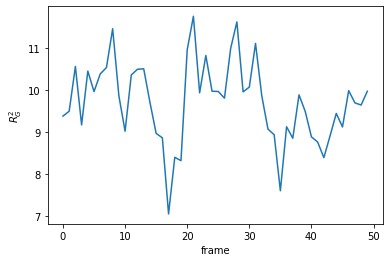

In [84]:
rog = []
Os = peg_u.select_atoms('type os')
for ts in peg_u.trajectory:
    rog.append(Os.radius_of_gyration())

#now let's plot:
plt.plot(rog)
plt.xlabel('frame')
plt.ylabel(f'$R^2_G$')

### AdK opening

Now let's go back to the AdK trajectory and see what happens to the angles between domains as we iterate over the trajectory.

<div class="alert alert-success"> <b>Exercise</b> 


By looking at the section on [AdK opening](#angles), the example above and the pseudocode below, calculate and plot the angles. 


    theta_NMP_traj = []
    theta_LID_traj = []

    for ts in adk_u.trajectory:
    
        calculate.theta_NMP
        calculate.theta_LID
        #remember to convert to degrees with np.rad2deg()
        theta_NMP_traj.append(theta_NMP)
        theta_LID_traj.append(theta_LID)
     

    
</div>

Text(0, 0.5, 'Angle')

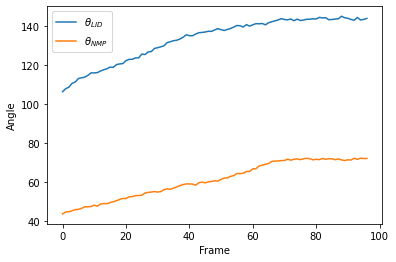

In [103]:
theta_NMP_traj = []
theta_LID_traj = []


for ts in adk_u.trajectory:

    A_NMP = adk_u.select_atoms('resid 115-125 and (backbone or name CB)').center_of_geometry()
    B_NMP = adk_u.select_atoms('resid 90-100 and (backbone or name CB)').center_of_geometry()
    C_NMP = adk_u.select_atoms('resid 35-55 and (backbone or name CB)').center_of_geometry()

    A_LID = adk_u.select_atoms('resid 179-185 and (backbone or name CB)').center_of_geometry()
    B_LID = adk_u.select_atoms('resid 112-125 and (backbone or name CB)').center_of_geometry()
    C_LID = adk_u.select_atoms('resid 125-153 and (backbone or name CB)').center_of_geometry()


    theta_NMP = mda.lib.distances.calc_angles(A_NMP, B_NMP, C_NMP)
    theta_LID = mda.lib.distances.calc_angles(A_LID, B_LID, C_LID)

    theta_LID_traj.append(np.rad2deg(theta_LID))
    theta_NMP_traj.append(np.rad2deg(theta_NMP))
    

Text(0, 0.5, 'Angle')

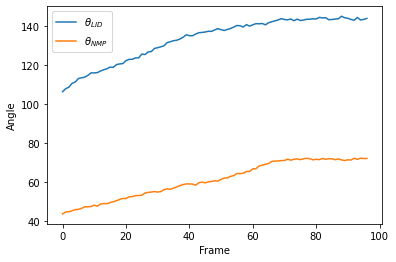

In [104]:
#now let's plot:
plt.plot(theta_LID_traj, label=r'$\theta_{LID}$')
plt.plot(theta_NMP_traj, label=r'$\theta_{NMP}$')
plt.legend()
plt.xlabel('Frame')
plt.ylabel('Angle')